In [1]:
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from scipy import ndimage

In [2]:
%matplotlib inline

In [3]:
# utils

def load_image(filename, as_gray=False, as_float=False):
    if as_gray:
        a = np.asarray(Image.open(filename).convert('L'))
    else:
        a = np.asarray(Image.open(filename))
    if as_float:
        return a.astype(np.float) / 255
    else:
        return a

def display_image(im, as_gray=False, title=None):
    plt.figure(figsize=(9,4))
    if as_gray:
        plt.imshow(im, cmap='gray')
    else:
        plt.imshow(im)
    if title is not None:
        plt.title(title)

def display_vec(v, title=None):
    plt.figure(figsize=(9,4))
    plt.plot(v)
    if title is not None:
        plt.title(title)

In [5]:
# syntax examples

range(10) # 0..9
range(1,10) # 1..9

# loop in image
def loop_sample(im):
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            v = im[i,j]

# create vector, matrix
np.zeros((3,), dtype=int)
np.zeros((3,4), dtype=int)

# get element count
# im.size

# define function
def f(arg):
    return 0

In [6]:
import cv2

In [7]:
# execute this for all files in https://drive.google.com/open?id=14pfOYIZm31Zro5Suq8BATdHdPPivAfXN
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving chessboard.png to chessboard.png
Saving circles.png to circles.png
Saving doc.jpg to doc.jpg
Saving doc.png to doc.png
Saving ensea_locaux.jpg to ensea_locaux.jpg
Saving IMG_1786-2.jpg to IMG_1786-2.jpg
Saving IMG_1787-2.jpg to IMG_1787-2.jpg
Saving IMG_1788-2.jpg to IMG_1788-2.jpg
Saving fingerprint.png to fingerprint.png
Saving lena512color.jpg to lena512color.jpg
Saving mur_louvre.jpg to mur_louvre.jpg
User uploaded file "chessboard.png" with length 131303 bytes
User uploaded file "circles.png" with length 346130 bytes
User uploaded file "doc.jpg" with length 3076372 bytes
User uploaded file "doc.png" with length 8898064 bytes
User uploaded file "ensea_locaux.jpg" with length 5610420 bytes
User uploaded file "IMG_1786-2.jpg" with length 160834 bytes
User uploaded file "IMG_1787-2.jpg" with length 155549 bytes
User uploaded file "IMG_1788-2.jpg" with length 187918 bytes
User uploaded file "fingerprint.png" with length 134090 bytes
User uploaded file "lena512color.jpg" with len

# Plane rectification

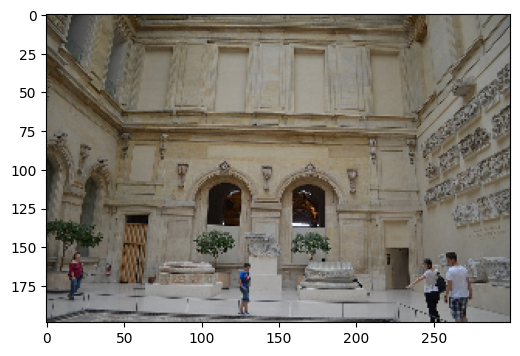

In [8]:
im = load_image('mur_louvre.jpg')
subsampling = 4
display_image(im[::subsampling,::subsampling])

In [9]:
# Exemple : ratio de hauteur entre porte de gauche et "fenetre" du haut ?

In [10]:
im_pts_sub = [(46,172), (233,177), (64,22), (226,26)]
ref_pts = [(0,0), (500,0), (0,300), (500,300)]

In [11]:
im_pts = im_pts_sub.copy()
for i in range(len(im_pts)):
    im_pts[i] = (subsampling*im_pts_sub[i][0], subsampling*im_pts_sub[i][1])

In [12]:
def calc_homography_DLT(ref_pts, im_pts):
    ## homography from ref_pts to im_pts
    M = np.zeros((9,9), dtype=np.float)
    for i in range(4):
      x_r, y_r = ref_pts[i]
      x_i, y_i = im_pts[i]

      M[i*2+0, 0] = x_r
      M[i*2+0, 1] = y_r
      M[i*2+0, 2] = 1
      M[i*2+0, 6] = -x_r*x_i
      M[i*2+0, 7] = -y_r*y_i
      M[i*2+0, 8] = -x_i

      M[i*2+1, 3] = -x_r
      M[i*2+1, 4] = -y_r
      M[i*2+1, 5] = -1
      M[i*2+1, 6] = -x_i*x_r
      M[i*2+1, 7] = -y_r*y_i
      M[i*2+1, 8] = -y_r
    M[-1,-1] = 0 ##
    b = np.zeros((9,), dtype=np.float)
    b[-1] = 0 ##

    H = np.linalg.solve(M,b).reshape([3,3])
    return H

In [ ]:
H = calc_homography_DLT(ref_pts, im_pts)

In [ ]:
def pt_homography(H, p):
    pp = np.matmul(H, np.asarray([p[0], p[1], 1.0]))
    return 0 ##

In [ ]:
# check homography
print("homography errors (pix, should be near-zero)")
for i in range(4):
    print(np.linalg.norm(pt_homography(H, ref_pts[i]) - im_pts[i]))

In [ ]:
def apply_homography(im_in, H, im_out):
    # apply homography
    for y in range(im_out.shape[0]):
        for x in range(im_out.shape[1]):
            p = np.matmul(H, np.asarray([x,y,1]))
            xi = np.clip(int(round(p[0]/p[2])),0,im_in.shape[1]-1)
            yi = np.clip(int(round(p[1]/p[2])),0,im_in.shape[0]-1)
            im_out[y,x] = im_in[yi,xi]

In [ ]:
# apply homography
display_image(im[::subsampling,::subsampling])

im_h = np.zeros((300, 500, 3), dtype=im.dtype)
apply_homography(im, H, im_h)
# draw a grid on im_h
im_h[:,::50] = 255
im_h[::50,:] = 255
display_image(im_h[::-1])

# Stitching

In [ ]:
# images from https://www.pyimagesearch.com/2018/12/17/image-stitching-with-opencv-and-python/

images = []
for f in ['IMG_1786-2.jpg', 'IMG_1787-2.jpg', 'IMG_1788-2.jpg']:
    images.append(load_image(f))

plt.figure(figsize=(10,4))
for i, im in enumerate(images):
    plt.subplot(1,len(images),i+1)
    plt.axis('off')
    plt.imshow(im);
plt.tight_layout()

In [ ]:
pts = []
pts_0 = [[11,332], [98,77], [299,372], [199,553]]
pts_1 = [[461,348], [533,114], [741,401], [655,582]]
pts.append(pts_0)
pts.append(pts_1)

In [ ]:
H10 = calc_homography_DLT(pts_1, pts_0)
# define bigger im1
im1ext = np.zeros((images[1].shape[0], images[1].shape[1]*2, images[1].shape[2]), dtype=images[1].dtype)
#apply_homography(images[0], H10, im1ext)
im1ext = cv2.warpPerspective(images[0], np.linalg.inv(H10), im1ext.shape[1::-1])

In [ ]:
display_image(im1ext)

In [ ]:
mask = im1ext[:,:images[1].shape[1]] == 0
im1ext[:,:images[1].shape[1]][mask] = images[1][mask]
display_image(im1ext)

# Automated homography

## RANSAC on line

In [ ]:
sz = 100
n = 1000
n_inliers = n * 5 // 100
pts = np.random.randint(0, sz, (n,2))
# overwrite inliers
pts[:n_inliers,0] = np.random.randint(0, sz, (n_inliers,))
pts[:n_inliers,1] = np.round(pts[:n_inliers,0] * 0.1234 + 56.78)

In [ ]:
# display points
im = np.zeros((sz,sz,3), dtype=np.uint8)
im[pts[:,1],pts[:,0]] = 255
display_image(im)

In [ ]:
def pts2line(p1, p2):
    if np.linalg.norm(p1 - p2) < 1.0:
        return ((0.0,0.0), (1.0,0.0))
    u = p2 - p1
    u = u / np.linalg.norm(u)
    return (p1, u)

def linedist(line, p):
    # projection on u ortho
    return np.abs(np.dot(p - line[0], np.asarray([line[1][1], -line[1][0]])))

def RANSAC_line(pts):
    N = pts.shape[0]
    best_line = None
    best_n = 0
    best_inliers = None
    for iter in range(1000):
        ids = np.random.choice(N, 2, replace=False)
        line = 0 ##
        inliers = []
        inlier_threshold = 1.0 # Distance threshold to identify inliers with line check
        for i in range(N):
            dist = 0 ##
            if dist < inlier_threshold:
                inliers.append(pts[i])
        # print((ids, len(inliers)))
        if len(inliers) > best_n:
            0 ##
    return (best_line, best_n)

In [ ]:
found_line, found_inliers = RANSAC_line(pts)
print('inliers found %d' % found_inliers)
# get line as y = ax+b from (p,u) representation
print(found_line)
b = found_line[0][1] - found_line[1][1] * found_line[0][0] / found_line[1][0]
a = found_line[1][1] / found_line[1][0]
print('line eq y=%fx+%f' % (a,b))

In [ ]:
# draw line on image
cv2.line(im, (0,int(round(b))), (sz,int(round(a*sz+b))), color=(255,0,0))
display_image(im)

## Towards automated stitching

In [ ]:
# https://docs.opencv.org/3.4/db/d70/tutorial_akaze_matching.html

from math import sqrt

# point matching
akaze = cv2.AKAZE_create()
kpts1, desc1 = akaze.detectAndCompute(images[0], None)
kpts2, desc2 = akaze.detectAndCompute(images[1], None)
matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_BRUTEFORCE_HAMMING)
nn_matches = matcher.knnMatch(desc1, desc2, 2)
matched1 = []
matched2 = []
nn_match_ratio = 0.8 # Nearest neighbor matching ratio
for m, n in nn_matches:
    if m.distance < nn_match_ratio * n.distance:
        matched1.append(kpts1[m.queryIdx])
        matched2.append(kpts2[m.trainIdx])

print('%d potential matches' % len(matched1))
matched1_np = np.asarray([(m.pt[0],m.pt[1]) for m in matched1])
matched2_np = np.asarray([(m.pt[0],m.pt[1]) for m in matched2])

# RANSAC on homographies
best_H = None
best_n = 0
best_inliers = None
for iter in range(1000):
    ids = np.random.choice(len(matched1), 4, replace=False)
    H = calc_homography_DLT(matched1_np[ids], matched2_np[ids])

    inliers1 = []
    inliers2 = []
    good_matches = []
    inlier_threshold = 2.5 # Distance threshold to identify inliers with homography check
    for i, m in enumerate(matched1):
        col = np.ones((3,1), dtype=np.float64)
        col[0:2,0] = m.pt
        pt2 = ##
        pt2 /= pt2[2,0]
        dist = ##
        if dist < inlier_threshold:
            good_matches.append(cv2.DMatch(len(inliers1), len(inliers2), 0))
            inliers1.append(matched1[i])
            inliers2.append(matched2[i])
    print((ids, len(inliers1)))
    if len(inliers1) > best_n:
        best_H = H
        best_n = len(inliers1)
        best_inliers = (inliers1,inliers2)

In [ ]:
best_n, best_H

In [ ]:
# define bigger im1
im1ext = np.zeros((images[1].shape[0], images[1].shape[1]*2, images[1].shape[2]), dtype=images[1].dtype)
#apply_homography(images[0], H10, im1ext)
im1ext = cv2.warpPerspective(images[0], best_H, im1ext.shape[1::-1])
mask = im1ext[:,:images[1].shape[1]] == 0
im1ext[:,:images[1].shape[1]][mask] = images[1][mask]
display_image(im1ext)